<a href="https://colab.research.google.com/github/Ghostbolt/LSTM/blob/main/Nike_Stock_Price_Prediction_using_LSTM_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Price Prediction using LSTM in Python**

**This notebook demonstrates how to predict stock prices using Long Short-Term Memory (LSTM) neural networks. We will use historical stock prices of Nike over a 10-year period.**

**Importing Required Libraries :**

First, we import all the necessary libraries.

In [3]:
# Disable GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#!pip install yfinance
from google.colab import files
uploaded = files.upload()

# Importing Libraries
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import io


Saving nike.csv to nike (1).csv


**Function to Fetch Stock Data :**

We create a function to fetch the historical stock data from Yahoo Finance using the yfinance library.

In [4]:
filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]))

df.head()

,Date,Close,Open,High,Low,Vol.,Change %
0,5/7/2025,58.24,57.77,58.80,57.60,5.23M,2.10%
1,5/6/2025,57.04,57.15,57.72,56.79,11.44M,-0.54%
2,5/5/2025,57.35,58.12,58.34,57.29,15.97M,-2.12%
3,5/2/2025,58.59,57.87,58.70,57.31,14.72M,3.22%
4,5/1/2025,56.76,56.68,57.21,56.26,10.53M,0.64%


**Plotting Fetched Data :**

We plot the closing price history of the stock.

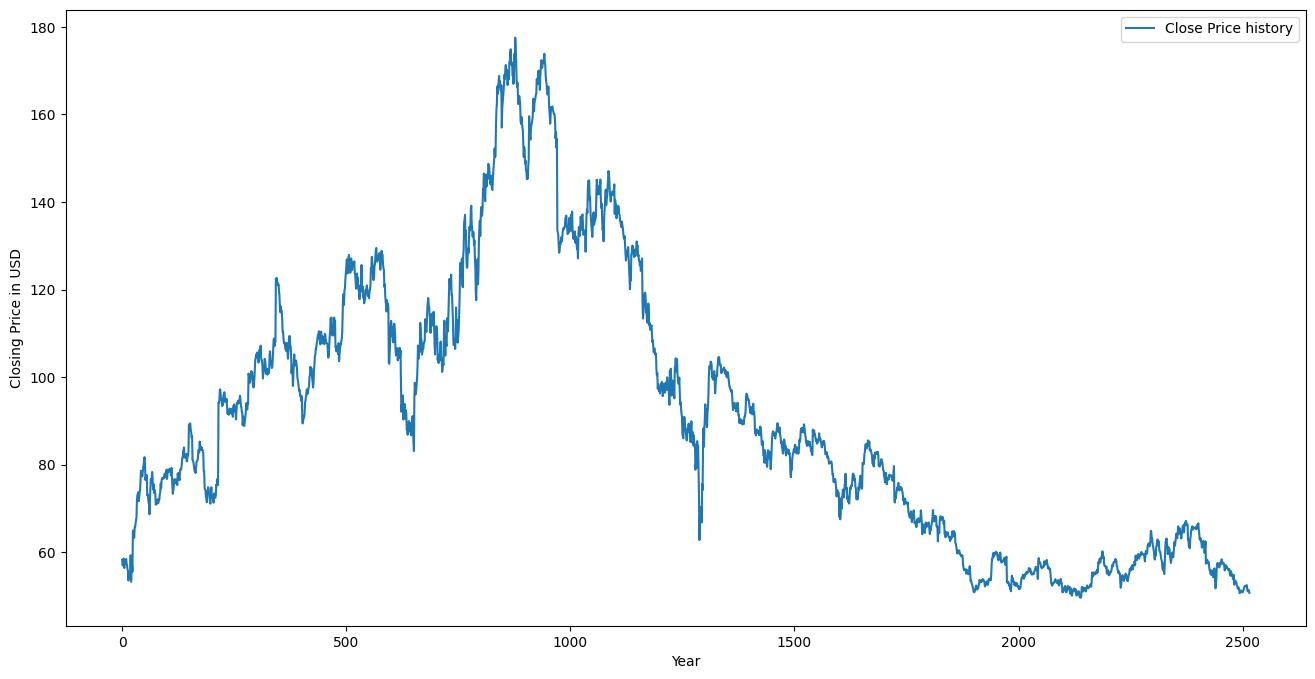

In [5]:
fig = plt.figure(figsize=(16,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in USD")
plt.plot(df['Close'], label='Close Price history')
plt.legend()
plt.show()


**Checking Data Types and Descriptive Statistics :**

We check the data types of each column and descriptive statistics to ensure data consistency.

In [6]:
df.dtypes
df.describe()


,Close,Open,High,Low
count,2516.000000,2516.000000,2516.000000,2516.000000
mean,90.754571,90.758955,91.691137,89.816574
std,31.334721,31.368034,31.673746,31.022344
min,49.620000,49.240000,50.000000,47.250000
25%,62.920000,62.895000,63.490000,62.270000
50%,85.250000,85.115000,85.890000,84.365000
75%,109.315000,109.385000,110.530000,108.160000
max,177.510000,176.350000,179.100000,175.490000


**Resetting Index and Dropping Unnecessary Columns :**

We reset the index to make the date a column and drop columns that are not required for our analysis.

KeyError: "['Dividends', 'Stock Splits'] not found in axis"

**Creating Dataset with Closing Price :**

We create a dataset with only the closing price column and set the date as the index.

In [9]:
data = df.sort_index(ascending=True, axis=0)
df1 = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
for i in range(0, len(data)):
    df1["Date"][i] = data['Date'][i]
    df1["Close"][i] = data["Close"][i]

df1.index = df1.Date
df1.drop("Date", axis=1, inplace=True)
df1.head()


,Close
Date,
5/7/2025,58.24
5/6/2025,57.04
5/5/2025,57.35
5/2/2025,58.59
5/1/2025,56.76


**Splitting Data into Train and Test Sets :**

We split the data into training and testing sets.

In [10]:
data = df1.values
train = data[0:1750, :]
test = data[1750:, :]

print(train.shape)
print(test.shape)


(1750, 1)
(766, 1)


**Normalizing the Data :**

We normalize the data to the range of 0-1 using MinMaxScaler.

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)


**Preparing Training Data :**

We prepare the training data by creating sequences of 60 days to predict the next closing price.

In [13]:
x_train, y_train = [], []
window = 60

for i in range(window, len(train)):
    x_train.append(scaled_data[i-window:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


**Preparing Test Data :**

We prepare the test data in a similar manner to the training data.

In [14]:
inputs = df1[len(df1) - len(test) - window:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

x_test = []
for i in range(window, inputs.shape[0]):
    x_test.append(inputs[i-window:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


**Building the LSTM Model :**

We build and compile the LSTM model.

In [15]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

**Training the Model :**

We train the model on the training data.

In [16]:
model.fit(x_train, y_train, epochs=2, batch_size=64, verbose=2)


Epoch 1/2
27/27 - 6s - 216ms/step - loss: 0.0509
Epoch 2/2
27/27 - 1s - 55ms/step - loss: 0.0034


**Making Predictions :**

We make predictions on the test data and transform the results back to the original form.

In [17]:
closing_price = model.predict(x_test)
train_predict = model.predict(x_train)

closing_price = scaler.inverse_transform(closing_price)
train_predict = scaler.inverse_transform(train_predict)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


**Calculating Performance Metric :**

We calculate the Mean Squared Error (MSE) on the test data.

In [18]:
mse = math.sqrt(mean_squared_error(test, closing_price))
print(f"Root Mean Squared Error: {mse}")


Root Mean Squared Error: 8.471668824290585


**Plotting the Predictions :**

We plot the actual and predicted closing prices.

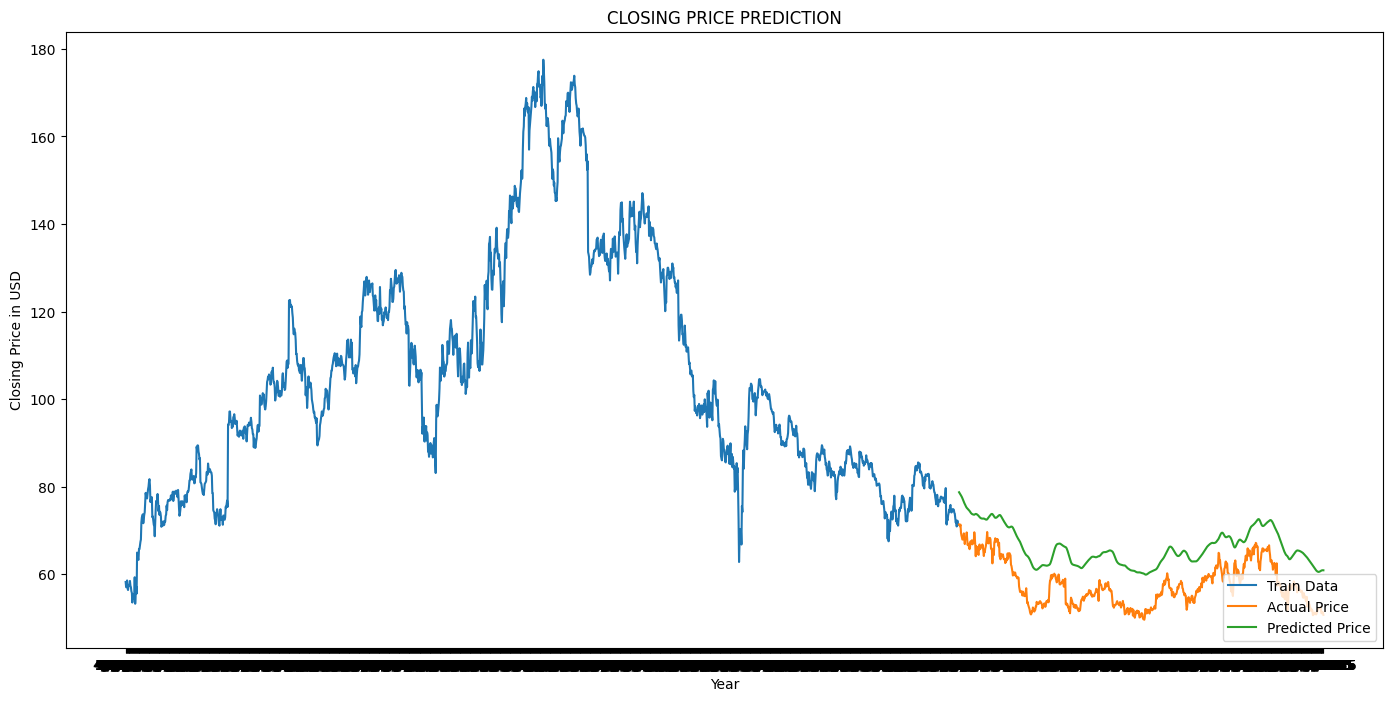

In [19]:
train = df1[:1750]
test = df1[1750:]
test['Predictions'] = closing_price

plt.figure(figsize=(17,8))
plt.xlabel("Year")
plt.ylabel("Closing Price in USD")
plt.title("CLOSING PRICE PREDICTION")
plt.plot(train['Close'])
plt.plot(test[['Close', 'Predictions']])
plt.legend(["Train Data", "Actual Price", "Predicted Price"], loc="lower right")
plt.show()


**The code provides a solid foundation for stock price prediction using LSTM.
While it has potential applications, achieving robust and reliable predictions for trading purposes would require more advanced techniques, extensive data, and thorough validation.**